In [7]:
!pip install tensorflow
!pip install tensorflow.python.tools
!pip install matplotlib



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


ERROR: Could not find a version that satisfies the requirement tensorflow.python.tools (from versions: none)
ERROR: No matching distribution found for tensorflow.python.tools

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ------------------------------------ 160.4/160.4 kB 962.3 kB/s eta 0:00:00
   ---------------------------------------- 7.6/7.6 MB 5.7 MB/s eta 0:00:00
   ---------------------------------------- 186.7/186.7 kB 3.8 MB/s eta 0:00:00
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 2.2/2.2 MB 8.7 MB/s eta 0:00:00
   ---------------------------------------- 56.1/56.1 kB 2.9 MB/s eta 0:00:00
   ---------------------------------------- 2.6/2.6 MB 6.7 MB/s eta 0:00:00


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
statsforecast 1.6.0 requires fugue>=0.8.1, which is not installed.
statsforecast 1.6.0 requires numba>=0.55.0, which is not installed.
statsforecast 1.6.0 requires polars, which is not installed.
statsforecast 1.6.0 requires statsmodels>=0.13.2, which is not installed.

[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
import tensorflow as tf
import tensorflow.python.tools

print(tf.__version__)

2.15.0


In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
df_train = pd.read_csv('train.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [11]:
#Create Validation Set
df_valid = pd.read_csv('test.csv')
df_gender = pd.read_csv('gender_submission.csv')

df_valid = pd.merge(df_valid, df_gender, on='PassengerId')
df_valid.dropna(subset=['Survived'], inplace=True)
df_valid.dropna(subset=['Fare'], inplace=True)

df_valid.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1


In [12]:
def manual_preprocess_df(df):
    df = df.drop(['Name', 'PassengerId', 'Cabin', 'Ticket'], axis = 1)
    df['Embarked'] = df['Embarked'].map({
        'C' : 0,
        'Q' : 1,
        'S' : 2
    })
    df['Sex'] = df['Sex'].map({
        'male' : 0,
        'female' : 1
    })
    df['Age'] = df['Age'].fillna(df['Age'].mean())
    df.dropna(subset=['Embarked'], inplace=True)
    return df

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [14]:
df_train = manual_preprocess_df(df_train)
df_valid = manual_preprocess_df(df_valid)

df_train.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,2.0
1,1,1,1,38.0,1,0,71.2833,0.0
2,1,3,1,26.0,0,0,7.9250,2.0
3,1,1,1,35.0,1,0,53.1000,2.0
4,0,3,0,35.0,0,0,8.0500,2.0


In [15]:
#Label - Data Splits
def label_data_split(df):
    y = df['Survived']
    x = df.loc[:, df.columns != 'Survived']
    return (x,y)

In [16]:
#Train - Test Split & Shuffling
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

df_train = shuffle(df_train)

(labels, targets) = label_data_split(df_train)

x_train, x_test, y_train, y_test = train_test_split(labels, targets, test_size=0.33)

In [17]:
#Scaler
from sklearn.preprocessing import StandardScaler

D = 7

dataScaler = StandardScaler()

x_train = dataScaler.fit_transform(x_train)
x_test = dataScaler.transform(x_test)

In [18]:
#Build Model With TF Keras Functional API
from tensorflow.keras.layers import Input, Dense, Dropout, LeakyReLU, LSTM
from tensorflow.keras.models import Model

i = Input(shape=(D,1))
x = LSTM(32, return_sequences=True, activation=LeakyReLU(alpha=0.2))(i)
x = Dropout(0.2)(x)
x = LSTM(64, return_sequences=True, activation=LeakyReLU(alpha=0.3))(x)
x = Dropout(0.2)(x)
x = LSTM(128, activation=LeakyReLU(alpha=0.3))(x)
x = Dropout(0.2)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(i,x)

In [19]:
from tensorflow.keras.optimizers import Adam

model.compile(
    loss = 'binary_crossentropy',
    optimizer = Adam(
        learning_rate=0.0011
    ),
    metrics = ['accuracy']
)

In [20]:
#Early Stop For Val_Accuracy
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_accuracy', patience=15)


In [21]:
r = model.fit(
    x_train,
    y_train,
    validation_data=(x_test,y_test),
    epochs = 150,
    callbacks=[early_stop]
)

Epoch 1/150


19/19 [==============================] - 7s 64ms/step - loss: 0.6822 - accuracy: 0.6000 - val_loss: 0.6627 - val_accuracy: 0.6395
Epoch 2/150
19/19 [==============================] - 0s 19ms/step - loss: 0.6684 - accuracy: 0.6067 - val_loss: 0.6522 - val_accuracy: 0.6395
Epoch 3/150
19/19 [==============================] - 0s 20ms/step - loss: 0.6648 - accuracy: 0.6067 - val_loss: 0.6581 - val_accuracy: 0.6395
Epoch 4/150
19/19 [==============================] - 0s 19ms/step - loss: 0.6521 - accuracy: 0.6034 - val_loss: 0.6376 - val_accuracy: 0.6395
Epoch 5/150
19/19 [==============================] - 0s 19ms/step - loss: 0.6380 - accuracy: 0.5950 - val_loss: 0.6401 - val_accuracy: 0.6259
Epoch 6/150
19/19 [==============================] - 0s 19ms/step - loss: 0.6207 - accuracy: 0.6034 - val_loss: 0.6083 - val_accuracy: 0.6361
Epoch 7/150
19/19 [==============================] - 0s 19ms/step - loss: 0.5916 - accuracy: 0.6437 - val_loss: 0.5878 - val_accuracy: 0.6871
Epoc

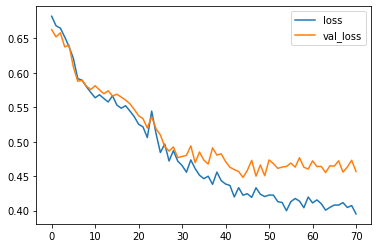

In [22]:
plt.plot(r.history['loss'], label = 'loss')
plt.plot(r.history['val_loss'], label = 'val_loss')

plt.legend()

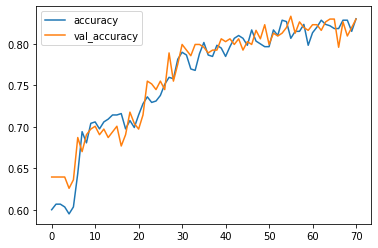

In [23]:
plt.plot(r.history['accuracy'], label = 'accuracy')
plt.plot(r.history['val_accuracy'], label = 'val_accuracy')

plt.legend()

In [24]:
#Evaluate Split Train Data
split_evals = model.evaluate(
    x_test,
    y_test
)

10/10 [==============================] - 0s 6ms/step - loss: 0.4566 - accuracy: 0.8299


In [25]:
#Evaluate with merged submission sample
(x_valid, y_valid) = label_data_split(df_valid)

x_valid = dataScaler.transform(x_valid)

merged_evals = model.evaluate(
    x_valid,
    y_valid
)

14/14 [==============================] - 0s 6ms/step - loss: 0.3358 - accuracy: 0.9353


<BarContainer object of 4 artists>

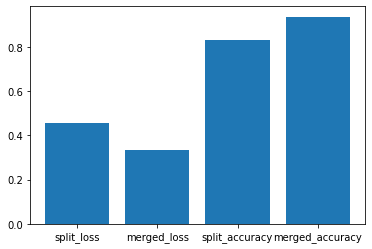

In [26]:
labels = ["split_loss", "merged_loss", "split_accuracy", "merged_accuracy"]
values = [split_evals[0], merged_evals[0], split_evals[1], merged_evals[1]]

plt.bar(labels, values)

## Create Submission

In [28]:
prediction_df = pd.read_csv('test.csv')

prediction_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [29]:
prediction_df_processed = manual_preprocess_df(prediction_df)

prediction_df_processed.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,34.5,0,0,7.8292,1
1,3,1,47.0,1,0,7.0000,2
2,2,0,62.0,0,0,9.6875,1
3,3,0,27.0,0,0,8.6625,2
4,3,1,22.0,1,1,12.2875,2


In [30]:
prediction_df_processed['Fare'] = prediction_df_processed['Fare'].fillna(prediction_df_processed['Fare'].mean())

In [31]:
x_prediction = dataScaler.transform(prediction_df_processed)

In [32]:
predictions = model.predict(
    x_prediction
)

14/14 [==============================] - 1s 6ms/step


In [33]:
result_df = pd.DataFrame(prediction_df)
result_df['Survived'] = predictions
result_df['Survived'] = result_df['Survived'].apply(lambda x: 1 if x > 0.5 else 0)


result_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0


In [34]:
result_df.drop(columns=[col for col in result_df.columns if col not in ['PassengerId', 'Survived']], inplace=True)

In [35]:
result_df.to_csv('submission.csv')